In [1]:
# imports 

import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import shapefile as shp

This dataset consists of 10 years of historical weather data from roughly 50 cities in Australia. This model will use weather observations taken at a city and use this data to try to predict if it will rain the following day. 

In [2]:
# set the style for the plotting in jupyter 

sns.set(style= 'whitegrid', palette='pastel', color_codes=True)
sns.mpl.rc('figure', figsize=(10,6))

%matplotlib inline

In [3]:
# get the data in 

raw_df = pd.read_csv(r'C:\Users\Devin\desktop\thinkful\capstone2\weatherAUS.csv')

In [4]:
# get the info on the dataset 

raw_df.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 145460 entries, 0 to 145459
Data columns (total 23 columns):
 #   Column         Non-Null Count   Dtype  
---  ------         --------------   -----  
 0   Date           145460 non-null  object 
 1   Location       145460 non-null  object 
 2   MinTemp        143975 non-null  float64
 3   MaxTemp        144199 non-null  float64
 4   Rainfall       142199 non-null  float64
 5   Evaporation    82670 non-null   float64
 6   Sunshine       75625 non-null   float64
 7   WindGustDir    135134 non-null  object 
 8   WindGustSpeed  135197 non-null  float64
 9   WindDir9am     134894 non-null  object 
 10  WindDir3pm     141232 non-null  object 
 11  WindSpeed9am   143693 non-null  float64
 12  WindSpeed3pm   142398 non-null  float64
 13  Humidity9am    142806 non-null  float64
 14  Humidity3pm    140953 non-null  float64
 15  Pressure9am    130395 non-null  float64
 16  Pressure3pm    130432 non-null  float64
 17  Cloud9am       89572 non-null

Ok, so the rain tomorrow column is the target for this project. We have data detailing temperature, rain, sun, wind, cloudcover, humidity and pressure. I feel it will be possible to predict the presence of rain within a reasonable 
level of accuracy. The cities sampled comprise a wide variety of climates, from tropical islands to desert. For such a wide variety of locations, and limited data to predict (only today's weather) I expect a limited amount of accuracy. Nonetheless, lets see how accurate it can be. 

There is a couple of issues here. The date is an object, I will have to change that to a time series object instead. The wind directions are all objects as well. Rain today and tomorrow will have to be changed to integers (binary) as well. 

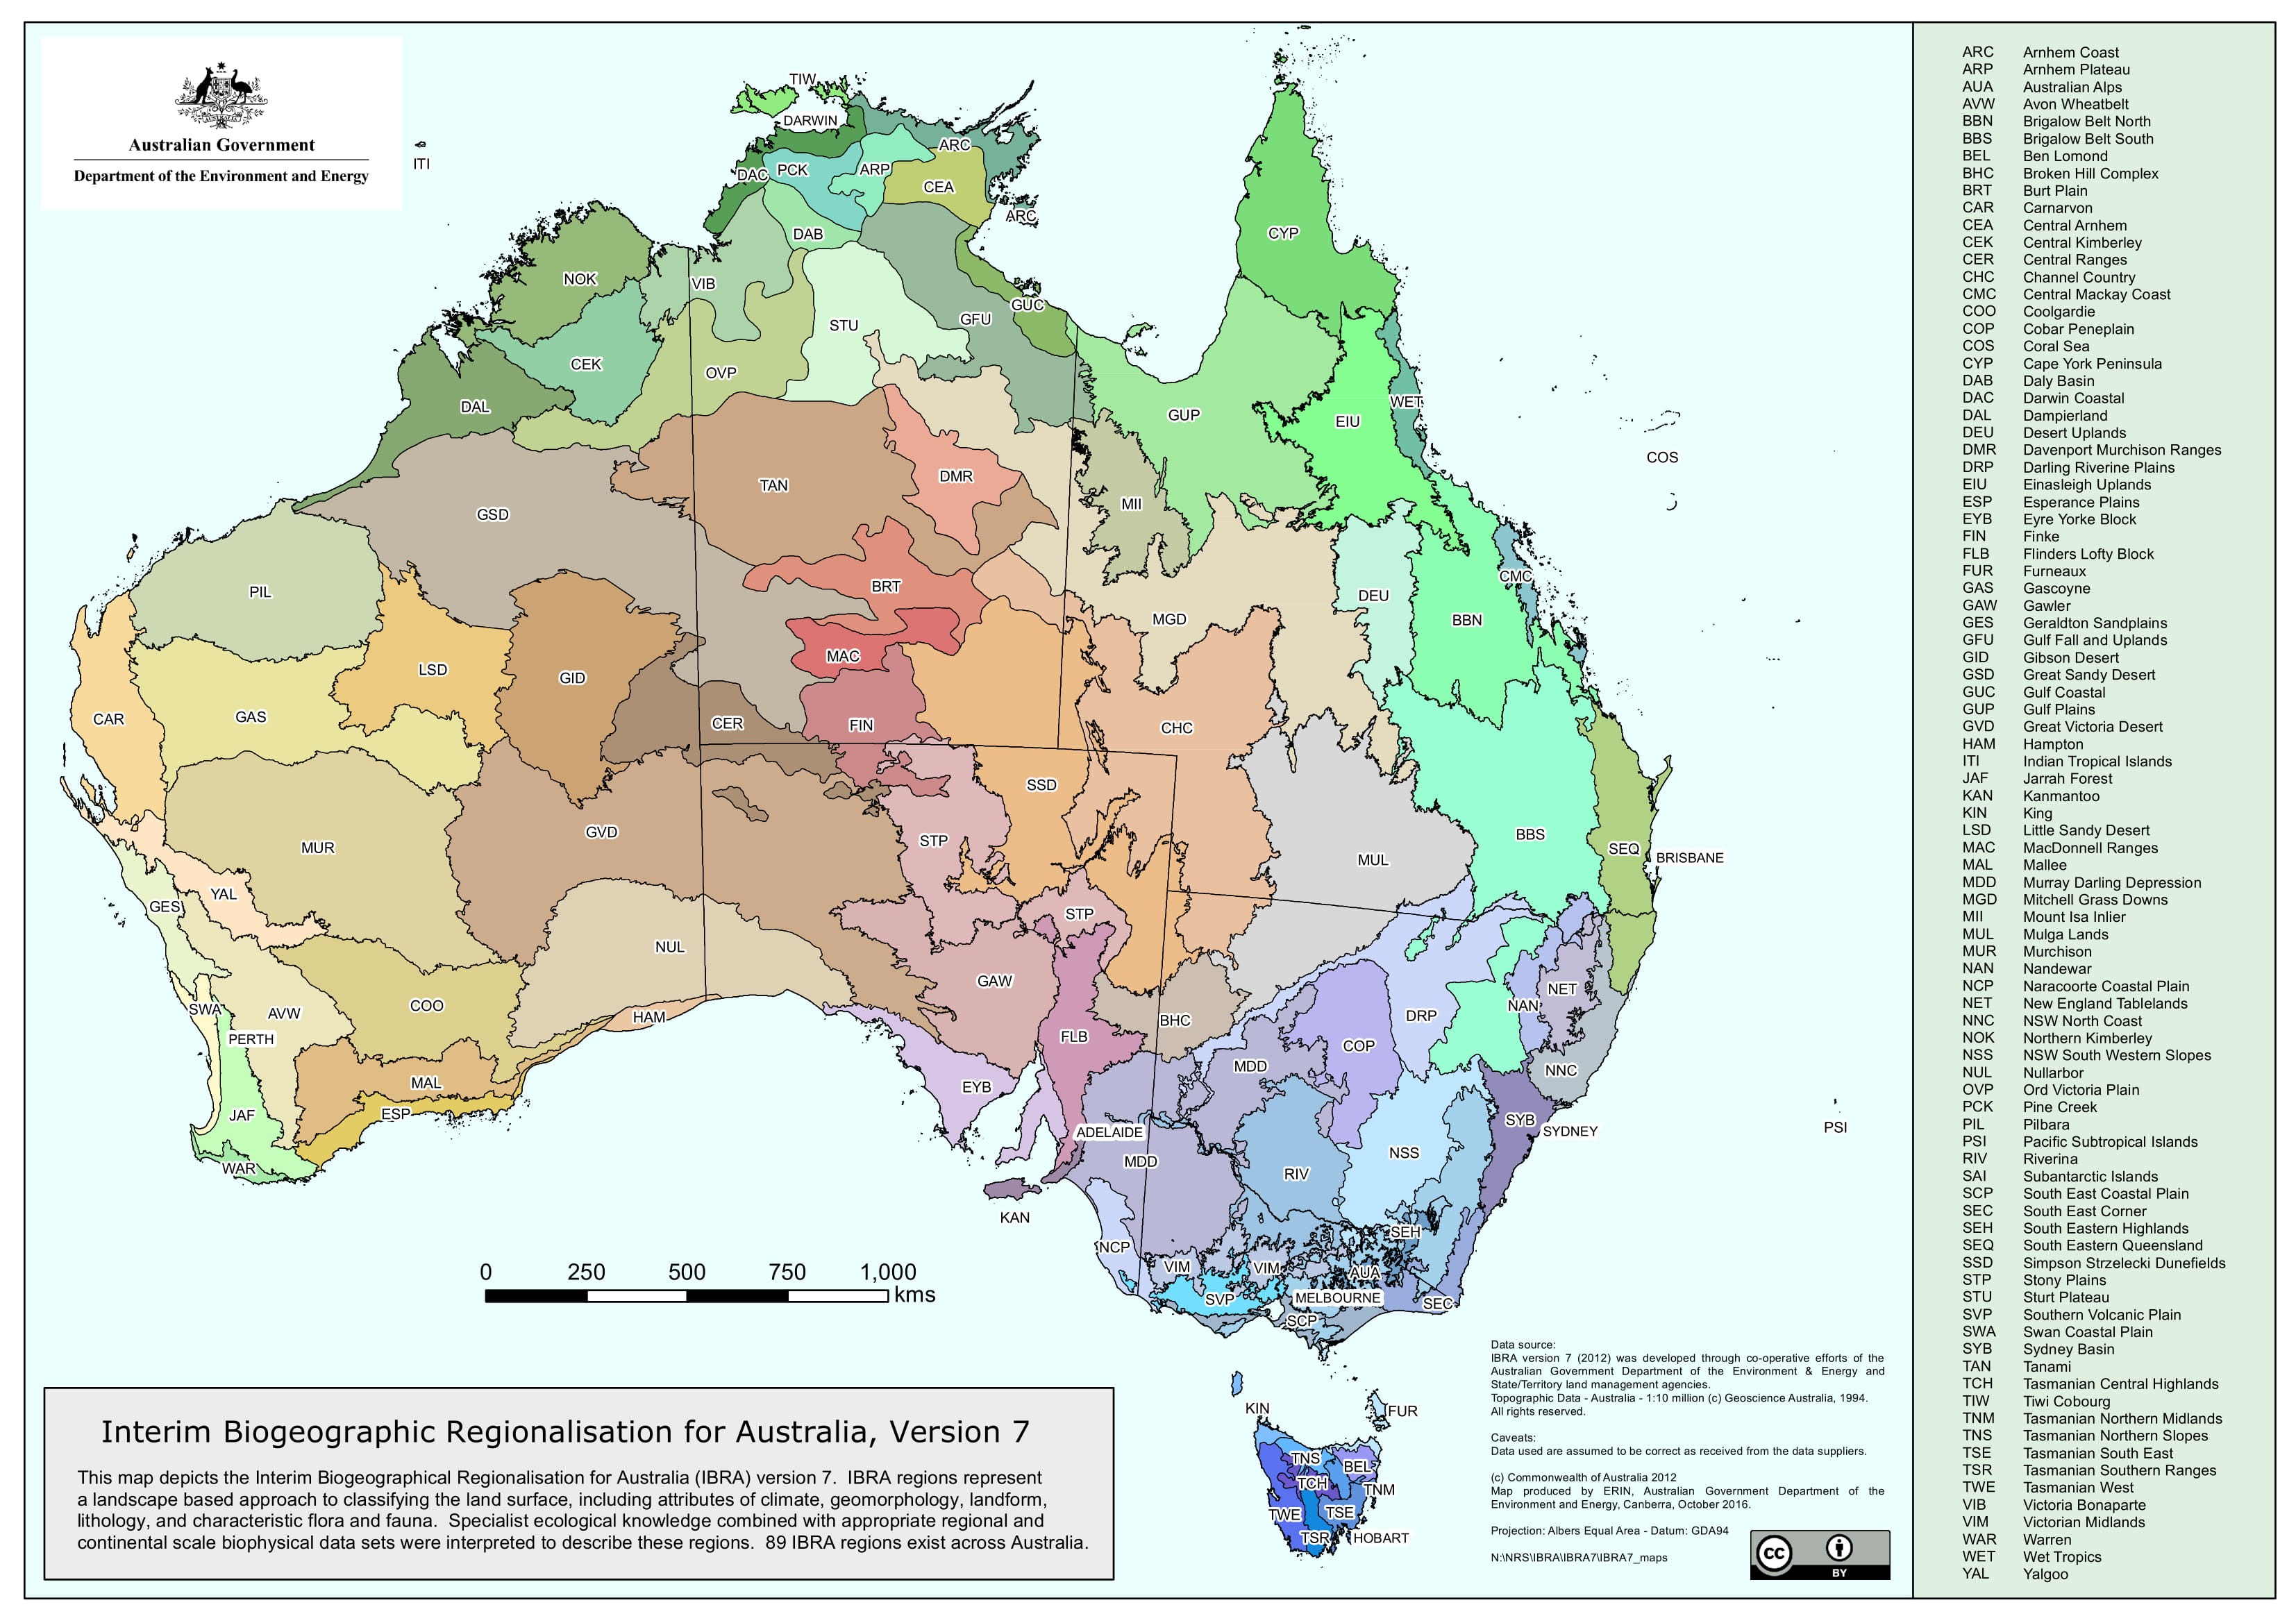

In [5]:
from IPython.display import Image
Image(r'C:\Users\Devin\desktop\thinkful\capstone2\images\bioregions-new\bioregions-new-1.jpg')

Image detailing Australia's 89 disparate biogeographic regions. This gives background on the difficulty of predicitng weather for 50 cities scattered through the continent. 

In [6]:
# ok, lets start by working with the nan values and coming up with a good way to deal with them 

# first get a list of the columns with missing values 

raw_df.isna().any()

# missing values for every column except the date and location 

Date             False
Location         False
MinTemp           True
MaxTemp           True
Rainfall          True
Evaporation       True
Sunshine          True
WindGustDir       True
WindGustSpeed     True
WindDir9am        True
WindDir3pm        True
WindSpeed9am      True
WindSpeed3pm      True
Humidity9am       True
Humidity3pm       True
Pressure9am       True
Pressure3pm       True
Cloud9am          True
Cloud3pm          True
Temp9am           True
Temp3pm           True
RainToday         True
RainTomorrow      True
dtype: bool

In [7]:
# get the number of missing values for all of the columns 
raw_df.isna().sum()

Date                 0
Location             0
MinTemp           1485
MaxTemp           1261
Rainfall          3261
Evaporation      62790
Sunshine         69835
WindGustDir      10326
WindGustSpeed    10263
WindDir9am       10566
WindDir3pm        4228
WindSpeed9am      1767
WindSpeed3pm      3062
Humidity9am       2654
Humidity3pm       4507
Pressure9am      15065
Pressure3pm      15028
Cloud9am         55888
Cloud3pm         59358
Temp9am           1767
Temp3pm           3609
RainToday         3261
RainTomorrow      3267
dtype: int64

Lots of missing values for clouds, evaporation and sunshine. Are these grouped by the location? Do specific weather stations lack the equipment to make these measurements or are they just missing? Lets explore this question. 

In [8]:
# clouds, evap and sunshine have many missing values , almost half 

# lets group by the location and see if it is consistent across weather reporting locations

location_grp = raw_df.groupby(['Location'])

In [9]:

# apply this labda function to get the number of missing values for evaporation grouped by the location 

location_grp['Evaporation'].apply( lambda x : x.isna().sum())

#seems mixed, some stations are missing all of the values, others are just missing some 

Location
Adelaide            1489
Albany               290
Albury              3040
AliceSprings         215
BadgerysCreek       3009
Ballarat            3040
Bendigo             1855
Brisbane              19
Cairns               370
Canberra            1604
Cobar                343
CoffsHarbour        1224
Dartmoor             409
Darwin                54
GoldCoast           3040
Hobart                 7
Katherine             93
Launceston          2899
Melbourne              3
MelbourneAirport       3
Mildura              117
Moree                717
MountGambier         410
MountGinini         3040
Newcastle           3039
Nhil                1578
NorahHead           3004
NorfolkIsland        234
Nuriootpa            122
PearceRAAF          3009
Penrith             3039
Perth                  1
PerthAirport           1
Portland             409
Richmond            1385
Sale                1175
SalmonGums          3001
Sydney                51
SydneyAirport         46
Townsville      

In [10]:
# lets look at clouds 
#same idea here for 9am clouds 

location_grp['Cloud9am'].apply(lambda x: x.isna().sum())

# roughly the same trend here.. 

Location
Adelaide            3193
Albany                38
Albury              1751
AliceSprings         334
BadgerysCreek       3009
Ballarat             546
Bendigo              968
Brisbane               1
Cairns               207
Canberra            1072
Cobar                380
CoffsHarbour         813
Dartmoor            3009
Darwin                 1
GoldCoast           3040
Hobart              1163
Katherine             41
Launceston          2315
Melbourne           1034
MelbourneAirport       0
Mildura               84
Moree                538
MountGambier         110
MountGinini         3040
Newcastle            241
Nhil                1578
NorahHead           3004
NorfolkIsland         66
Nuriootpa            127
PearceRAAF          1043
Penrith             3039
Perth                  2
PerthAirport           2
Portland             412
Richmond            2404
Sale                 358
SalmonGums          3001
Sydney               568
SydneyAirport          4
Townsville      

In [11]:
# examine the distribution of the wind directions 

raw_df['WindGustDir'].value_counts()

# fairly normal distribution here 

W      9915
SE     9418
N      9313
SSE    9216
E      9181
S      9168
WSW    9069
SW     8967
SSW    8736
WNW    8252
NW     8122
ENE    8104
ESE    7372
NE     7133
NNW    6620
NNE    6548
Name: WindGustDir, dtype: int64

Seems like the missing values were generally grouped by location. They weren't missing all of their values, therefore it seems that there wasn't just an issue of missing equipment at these stations. It is difficult to know why the data is missing. 

Now, the next order of buisness is the wind direction data. Currently, the data is all in object form. I am going to encode these from letter directions to degrees. This will result in far less dimensions for the algorithm than one hot encoding. 

In [12]:
# WindGustDir, WindDir9am, WindDir3pm are all objects, 


# ok, lets change these to compass directions 
#lets use a dictionary replace method 

#define the dictionary, consistent to first degree belonging to category 

compass_dir = { 'W': 258.75, 'SE': 123.75, 'N': 348.75, 'SSE': 146.25, 'E': 78.75, 'S': 168.75, 'WSW': 236.5, 'SW': 213.75, 
               'SSW': 191.25, 'WNW': 281.25, 'NW': 303.75, 'ENE': 56.25, 'ESE': 101.25, 'NE': 33.75, 'NNW': 326.25, 'NNE':11.25}

raw_df['WindGustDir'].replace(compass_dir, inplace=True)



In [13]:
raw_df['WindDir9am'].replace(compass_dir, inplace=True)

raw_df['WindDir3pm'].replace(compass_dir, inplace=True)

In [14]:
raw_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 145460 entries, 0 to 145459
Data columns (total 23 columns):
 #   Column         Non-Null Count   Dtype  
---  ------         --------------   -----  
 0   Date           145460 non-null  object 
 1   Location       145460 non-null  object 
 2   MinTemp        143975 non-null  float64
 3   MaxTemp        144199 non-null  float64
 4   Rainfall       142199 non-null  float64
 5   Evaporation    82670 non-null   float64
 6   Sunshine       75625 non-null   float64
 7   WindGustDir    135134 non-null  float64
 8   WindGustSpeed  135197 non-null  float64
 9   WindDir9am     134894 non-null  float64
 10  WindDir3pm     141232 non-null  float64
 11  WindSpeed9am   143693 non-null  float64
 12  WindSpeed3pm   142398 non-null  float64
 13  Humidity9am    142806 non-null  float64
 14  Humidity3pm    140953 non-null  float64
 15  Pressure9am    130395 non-null  float64
 16  Pressure3pm    130432 non-null  float64
 17  Cloud9am       89572 non-null

Looks good, all the wind directions have been encoded. Now the rain today and tomorrow columns have to be encoded to binary. 

In [15]:
# now we got to replace some values for the Rain today and tommorow columns 
raw_df['RainToday'].value_counts() 

# it is a binary, just make it 0 and 1 

No     110319
Yes     31880
Name: RainToday, dtype: int64

In [16]:
binary_dict = {'Yes': 1, 'No': 0}

raw_df['RainToday'].replace(binary_dict, inplace=True)

raw_df['RainTomorrow'].replace(binary_dict, inplace=True)

It is time to deal with location and date. Date can be changed to a pandas data time object, and then the integer value of year, month, and day can be extracted and turned into seperate columns. 

In [17]:
# look at the head of the date time to make the format string 

raw_df['Date']

# year , month , day 

0         2008-12-01
1         2008-12-02
2         2008-12-03
3         2008-12-04
4         2008-12-05
             ...    
145455    2017-06-21
145456    2017-06-22
145457    2017-06-23
145458    2017-06-24
145459    2017-06-25
Name: Date, Length: 145460, dtype: object

In [18]:
# change it 

raw_df['Date'] = pd.to_datetime(raw_df['Date'], format = '%Y-%m-%dT', errors='coerce')

In [19]:
#sucess!
raw_df['Date'].isna().any()

# now seperate these all into their own features 

False

In [20]:
# seperating into the seperate features 
raw_df['year'] = raw_df['Date'].dt.year
raw_df['month'] = raw_df['Date'].dt.month
raw_df['day'] = raw_df['Date'].dt.day

In [21]:
# check it out 
raw_df[['year', 'month', 'day']].head()

#looks good 


,year,month,day
0,2008,12,1
1,2008,12,2
2,2008,12,3
3,2008,12,4
4,2008,12,5


Lets examine the correlation of these features with the target 

Some of them may be dropped or not used. There is a lot of missing values for some of them 

In [22]:
corr = raw_df.corr()


<AxesSubplot:>

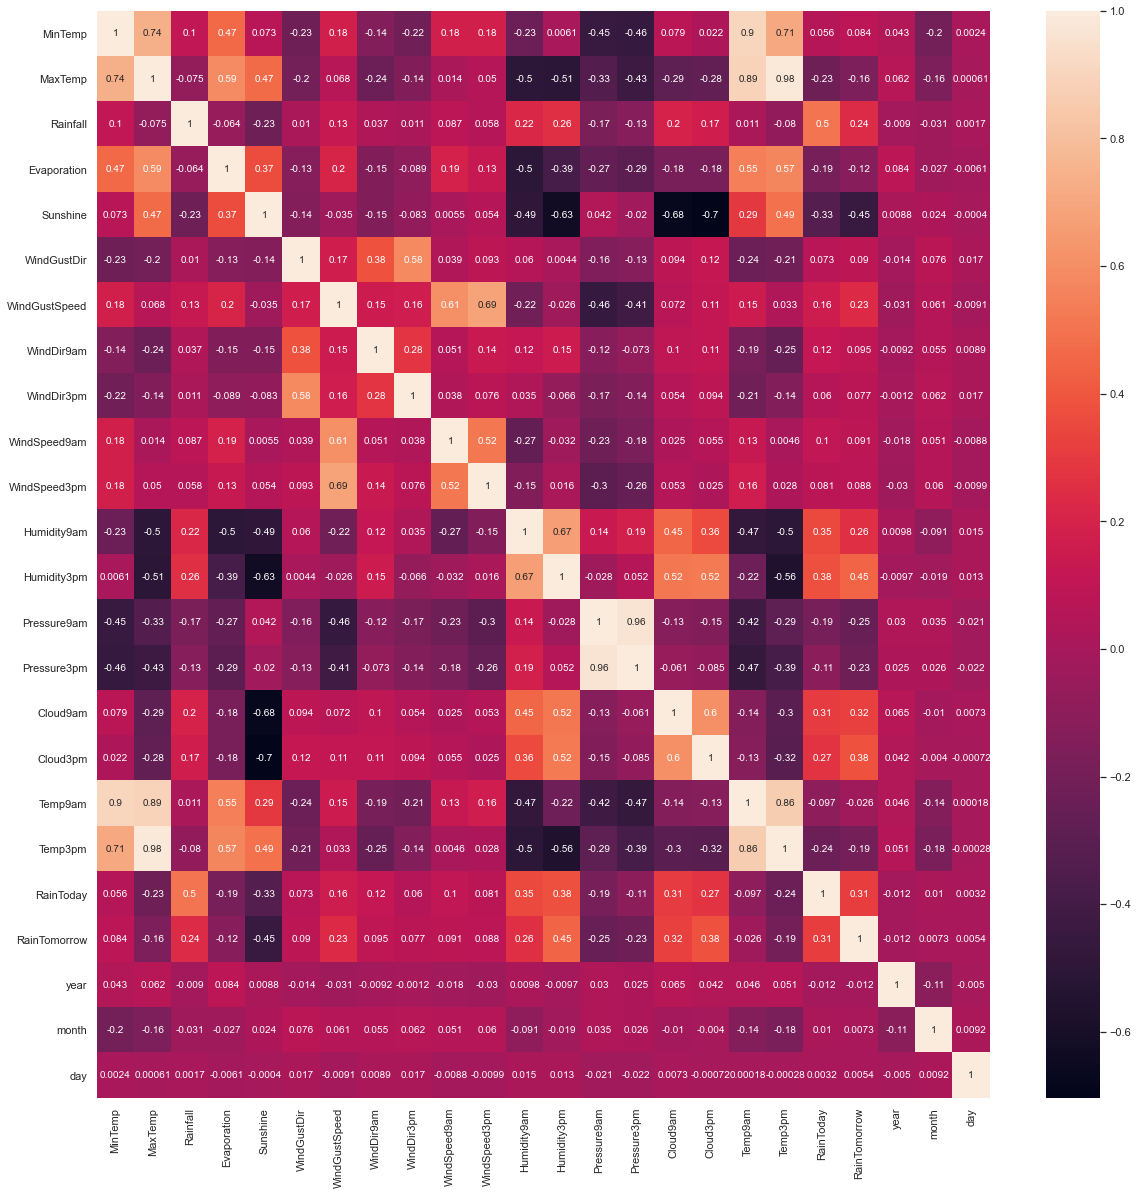

In [23]:
fig, ax = plt.subplots(figsize=(20,20))  
sns.heatmap(corr, annot=True)

all wind variables except WindGustSpeed have very low correrlation with the target 

all time variables have low correlation with the target as well 

Unfortunately, despite missing large amounts of values, evap, sunshine, and cloud cover are some of the most highly correlated with the target.  

Temperature is highly correlated with other temperature values. This makes sense, as one would expect early morning temperatures to be highly correlated with the temp of the afternoon. 

In [24]:
percent_miss = raw_df.isnull().sum() * 100 / len(raw_df)
missing = pd.DataFrame({'column_name': raw_df.columns,
                                 'percent_missing': percent_miss})

In [25]:
missing

,column_name,percent_missing
Date,Date,0.000000
Location,Location,0.000000
MinTemp,MinTemp,1.020899
MaxTemp,MaxTemp,0.866905
Rainfall,Rainfall,2.241853
Evaporation,Evaporation,43.166506
Sunshine,Sunshine,48.009762
WindGustDir,WindGustDir,7.098859
WindGustSpeed,WindGustSpeed,7.055548
WindDir9am,WindDir9am,7.263853


Towards data science recomends dropping data when there is 60% or more of a given column missing. In this case, none of these columns are at the threshold. Despite missing nearly 50% of their respective values, sunshine and temperature are highly correlated with the target. These columns cannot be dropped from the model. 

In [26]:
# lets just impute the missing values, might have to return here if we get low accuracy 

#prepare df for imputing 

df_pre_imputed = raw_df[['MinTemp','MaxTemp','Rainfall','Evaporation','Sunshine','WindGustDir','WindGustSpeed','WindDir9am','WindDir3pm',
 'WindSpeed9am','WindSpeed3pm','Humidity9am','Humidity3pm','Pressure9am','Pressure3pm','Cloud9am','Cloud3pm','Temp9am','Temp3pm',
                    'RainToday', 'RainTomorrow']]


from sklearn.impute import SimpleImputer

imputer = SimpleImputer(strategy = 'median')

imputer.fit(df_pre_imputed)

X = imputer.transform(df_pre_imputed)

#DATE LOCATION not in, no missing values for these 

In [27]:
df_imputed = pd.DataFrame(X, columns= df_pre_imputed.columns, index = df_pre_imputed.index)

df_imputed.head()

,MinTemp,MaxTemp,Rainfall,Evaporation,Sunshine,WindGustDir,WindGustSpeed,WindDir9am,WindDir3pm,WindSpeed9am,...,Humidity9am,Humidity3pm,Pressure9am,Pressure3pm,Cloud9am,Cloud3pm,Temp9am,Temp3pm,RainToday,RainTomorrow
0,13.4,22.9,0.6,4.8,8.4,258.75,44.0,258.75,281.25,20.0,...,71.0,22.0,1007.7,1007.1,8.0,5.0,16.9,21.8,0.0,0.0
1,7.4,25.1,0.0,4.8,8.4,281.25,44.0,326.25,236.50,4.0,...,44.0,25.0,1010.6,1007.8,5.0,5.0,17.2,24.3,0.0,0.0
2,12.9,25.7,0.0,4.8,8.4,236.50,46.0,258.75,236.50,19.0,...,38.0,30.0,1007.6,1008.7,5.0,2.0,21.0,23.2,0.0,0.0
3,9.2,28.0,0.0,4.8,8.4,33.75,24.0,123.75,78.75,11.0,...,45.0,16.0,1017.6,1012.8,5.0,5.0,18.1,26.5,0.0,0.0
4,17.5,32.3,1.0,4.8,8.4,258.75,41.0,56.25,303.75,7.0,...,82.0,33.0,1010.8,1006.0,7.0,8.0,17.8,29.7,0.0,0.0


Now we have to deal with the location column. This is going to have to be one hot encoded 

In [28]:
from sklearn.preprocessing import OneHotEncoder 

encoder = OneHotEncoder()

loc = raw_df[['Location']]

location_encoded = encoder.fit_transform(loc)

# now put this to array 
location_encoded = location_encoded.toarray()

# now to data frame
location_encoded = pd.DataFrame(location_encoded)

location_encoded.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 145460 entries, 0 to 145459
Data columns (total 49 columns):
 #   Column  Non-Null Count   Dtype  
---  ------  --------------   -----  
 0   0       145460 non-null  float64
 1   1       145460 non-null  float64
 2   2       145460 non-null  float64
 3   3       145460 non-null  float64
 4   4       145460 non-null  float64
 5   5       145460 non-null  float64
 6   6       145460 non-null  float64
 7   7       145460 non-null  float64
 8   8       145460 non-null  float64
 9   9       145460 non-null  float64
 10  10      145460 non-null  float64
 11  11      145460 non-null  float64
 12  12      145460 non-null  float64
 13  13      145460 non-null  float64
 14  14      145460 non-null  float64
 15  15      145460 non-null  float64
 16  16      145460 non-null  float64
 17  17      145460 non-null  float64
 18  18      145460 non-null  float64
 19  19      145460 non-null  float64
 20  20      145460 non-null  float64
 21  21      14

Now it is time to merge the two dataframes (one hot encoded values and all other columns). I will build a dummy index column in both to perform the merge of the two dataframes, and then merge them. Upon merging, the dummy index will be dropped. 

In [29]:
# ok, need a common column to perform the merge, use the index  

df_imputed['index_key'] = df_imputed.index

location_encoded['index_key'] = location_encoded.index

In [30]:
#now add the encoded features to the imputed data frame 
# use the merge function 

merged = pd.merge(df_imputed, location_encoded)


In [31]:
# ok we got it 
merged.shape

#feature scaling, outliers 

(145460, 71)

In [32]:
#drop useless index column used for the merge
merged.drop('index_key', axis=1, inplace=True)

In [33]:
merged.columns

Index([      'MinTemp',       'MaxTemp',      'Rainfall',   'Evaporation',
            'Sunshine',   'WindGustDir', 'WindGustSpeed',    'WindDir9am',
          'WindDir3pm',  'WindSpeed9am',  'WindSpeed3pm',   'Humidity9am',
         'Humidity3pm',   'Pressure9am',   'Pressure3pm',      'Cloud9am',
            'Cloud3pm',       'Temp9am',       'Temp3pm',     'RainToday',
        'RainTomorrow',               0,               1,               2,
                     3,               4,               5,               6,
                     7,               8,               9,              10,
                    11,              12,              13,              14,
                    15,              16,              17,              18,
                    19,              20,              21,              22,
                    23,              24,              25,              26,
                    27,              28,              29,              30,
                    31,  

In [34]:
# add in the date variables 

merged['year'] = raw_df['year']

merged['month'] = raw_df['month']

merged['day'] = raw_df['day']

In [35]:
merged.head()

,MinTemp,MaxTemp,Rainfall,Evaporation,Sunshine,WindGustDir,WindGustSpeed,WindDir9am,WindDir3pm,WindSpeed9am,...,42,43,44,45,46,47,48,year,month,day
0,13.4,22.9,0.6,4.8,8.4,258.75,44.0,258.75,281.25,20.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2008,12,1
1,7.4,25.1,0.0,4.8,8.4,281.25,44.0,326.25,236.50,4.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2008,12,2
2,12.9,25.7,0.0,4.8,8.4,236.50,46.0,258.75,236.50,19.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2008,12,3
3,9.2,28.0,0.0,4.8,8.4,33.75,24.0,123.75,78.75,11.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2008,12,4
4,17.5,32.3,1.0,4.8,8.4,258.75,41.0,56.25,303.75,7.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2008,12,5


In [36]:
percent_miss = merged.isnull().sum() * 100 / len(merged)
percent_miss.value_counts()

0.0    73
dtype: int64

All of the missing values have been taken care of at this point. It is time to move on to inspecting outliers and dealing with them. 

In [37]:
lst = ['MinTemp',       'MaxTemp',      'Rainfall',   'Evaporation',
            'Sunshine',   'WindGustDir', 'WindGustSpeed',    'WindDir9am',
          'WindDir3pm',  'WindSpeed9am',  'WindSpeed3pm',   'Humidity9am',
         'Humidity3pm',   'Pressure9am',   'Pressure3pm',      'Cloud9am',
            'Cloud3pm',       'Temp9am',       'Temp3pm',     'RainToday',
        'RainTomorrow',          'year',         'month',           'day']

#tukey's method or the IQR method 
# get the third and first quartiles to start 
q75, q25 =np.percentile(merged[lst], [75,25])
iqr = q75-q25

for threshold in np.arange(1,5,0.5):
    min_val = q25 - (iqr*threshold)
    max_val = q75 + (iqr*threshold)
    print("The score threshold is: {}".format(threshold))
    print("Number of outliers is: {}".format(
        len((np.where((merged[lst] > max_val) 
                      | (merged[lst] < min_val))[0]))
    ))
    
    # ok we got a serious outlier issue here 

The score threshold is: 1.0
Number of outliers is: 697068
The score threshold is: 1.5
Number of outliers is: 658720
The score threshold is: 2.0
Number of outliers is: 592935
The score threshold is: 2.5
Number of outliers is: 567320
The score threshold is: 3.0
Number of outliers is: 514294
The score threshold is: 3.5
Number of outliers is: 466343
The score threshold is: 4.0
Number of outliers is: 436382
The score threshold is: 4.5
Number of outliers is: 436380


C:\conda\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
C:\conda\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
C:\conda\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
C:\conda\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the f

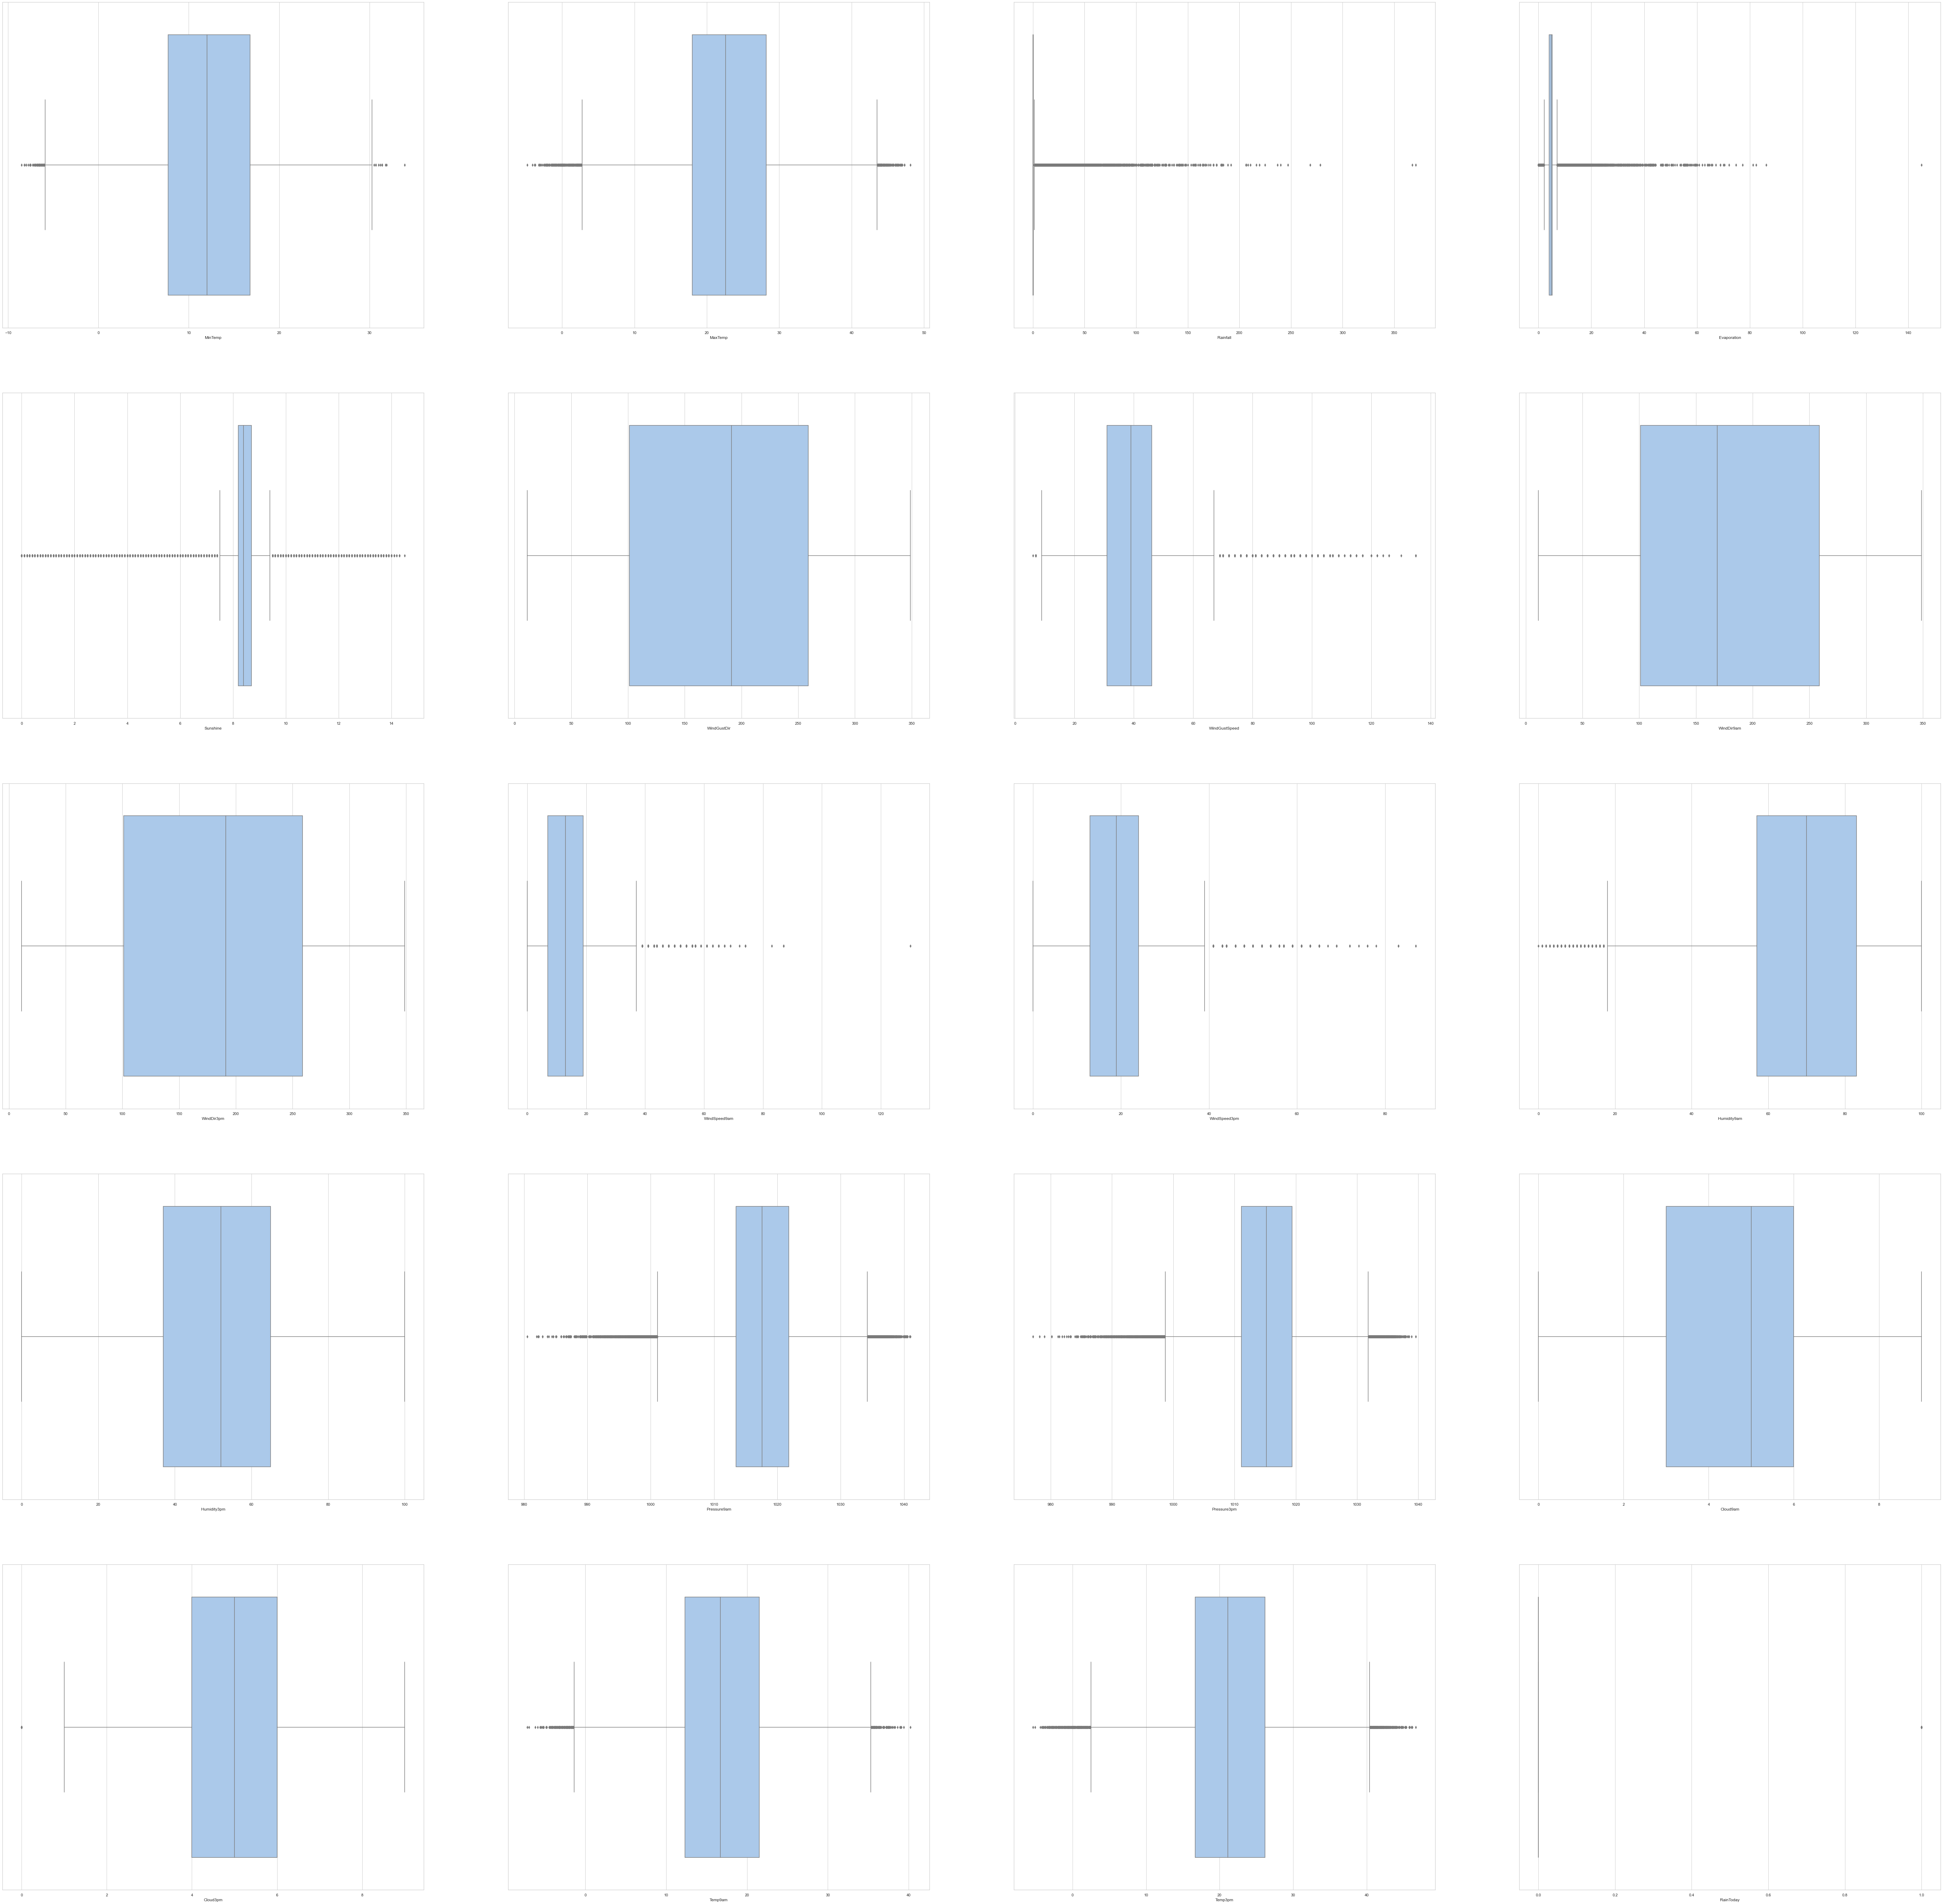

In [38]:
import seaborn as sns 
# lets plot em all in boxplots 

plt.figure(figsize = (100, 100))


plt.subplot(5,4,1)
sns.boxplot(merged[lst[0]])

plt.subplot(5,4,2)
sns.boxplot(merged[lst[1]])

plt.subplot(5,4,3)
sns.boxplot(merged[lst[2]])

plt.subplot(5,4,4)
sns.boxplot(merged[lst[3]])

plt.subplot(5,4,5)
sns.boxplot(merged[lst[4]])

plt.subplot(5,4,6)
sns.boxplot(merged[lst[5]])

plt.subplot(5,4,7)
sns.boxplot(merged[lst[6]])

plt.subplot(5,4,8)
sns.boxplot(merged[lst[7]])

plt.subplot(5,4,9)
sns.boxplot(merged[lst[8]])

plt.subplot(5,4,10)
sns.boxplot(merged[lst[9]])

plt.subplot(5,4,11)
sns.boxplot(merged[lst[10]])

plt.subplot(5,4,12)
sns.boxplot(merged[lst[11]])

plt.subplot(5,4,13)
sns.boxplot(merged[lst[12]])

plt.subplot(5,4,14)
sns.boxplot(merged[lst[13]])

plt.subplot(5,4,15)
sns.boxplot(merged[lst[14]])

plt.subplot(5,4,16)
sns.boxplot(merged[lst[15]])

plt.subplot(5,4,17)
sns.boxplot(merged[lst[16]])

plt.subplot(5,4,18)
sns.boxplot(merged[lst[17]])

plt.subplot(5,4,19)
sns.boxplot(merged[lst[18]])

plt.subplot(5,4,20)
sns.boxplot(merged[lst[19]])

plt.show()

# 19, 18, 17, 14, 13, 10, 9, 6, 4, 3, 2 all need some winsorizing 

Alright, apply a winsorization technique to remove some of the outliers. 

In [39]:
from scipy.stats.mstats import winsorize 

merged[lst[19]] = winsorize(merged[lst[19]], (0.10, 0.10))


merged[lst[18]] = winsorize(merged[lst[18]], (0.10, 0.10))


merged[lst[17]] = winsorize(merged[lst[17]], (0.10, 0.10))


merged[lst[14]] = winsorize(merged[lst[14]], (0.10, 0.10))


merged[lst[13]] = winsorize(merged[lst[13]], (0.10, 0.10))


merged[lst[10]] = winsorize(merged[lst[10]], (0.10, 0.10))


merged[lst[9]] = winsorize(merged[lst[9]], (0.10, 0.10))


merged[lst[6]] = winsorize(merged[lst[6]], (0.10, 0.10))


merged[lst[4]] = winsorize(merged[lst[4]], (0.10, 0.10))


merged[lst[3]] = winsorize(merged[lst[3]], (0.10, 0.10))


merged[lst[2]] = winsorize(merged[lst[2]], (0.10, 0.10))

Check to see how well that worked. 

C:\conda\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
C:\conda\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
C:\conda\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
C:\conda\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the f

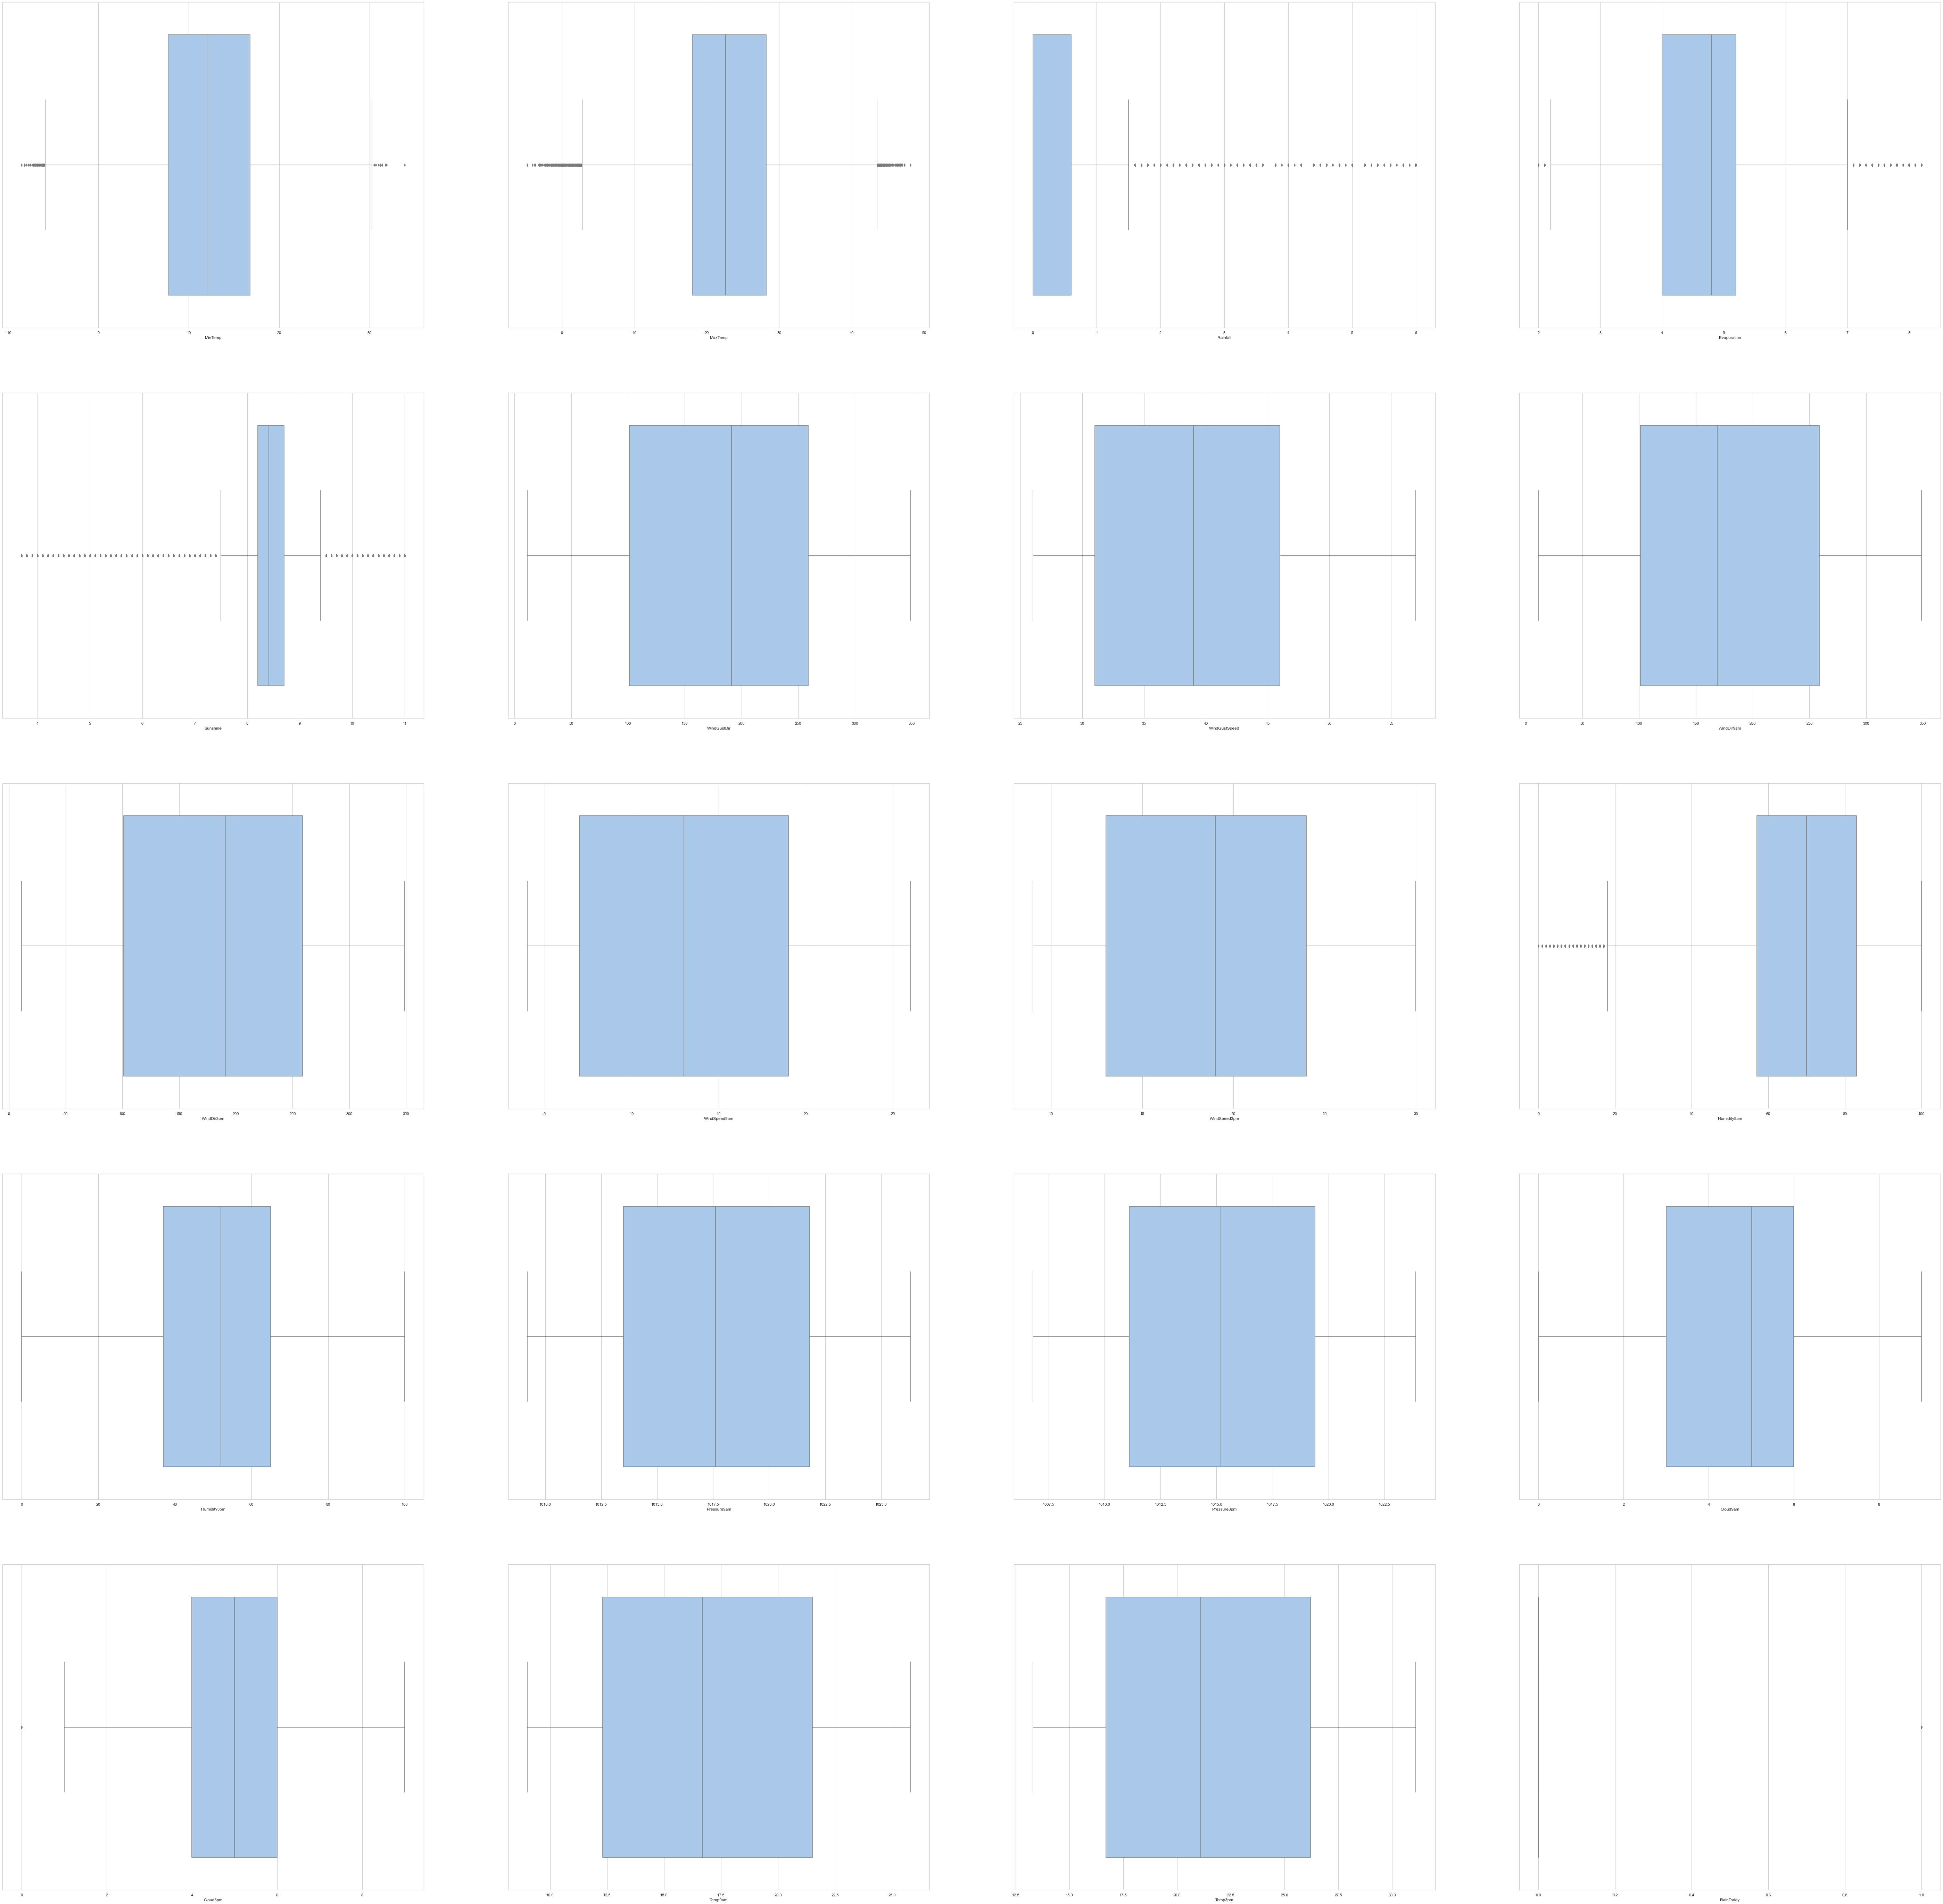

In [40]:
# lets plot em all in boxplots 

plt.figure(figsize = (100, 100))


plt.subplot(5,4,1)
sns.boxplot(merged[lst[0]])

plt.subplot(5,4,2)
sns.boxplot(merged[lst[1]])

plt.subplot(5,4,3)
sns.boxplot(merged[lst[2]])

plt.subplot(5,4,4)
sns.boxplot(merged[lst[3]])

plt.subplot(5,4,5)
sns.boxplot(merged[lst[4]])

plt.subplot(5,4,6)
sns.boxplot(merged[lst[5]])

plt.subplot(5,4,7)
sns.boxplot(merged[lst[6]])

plt.subplot(5,4,8)
sns.boxplot(merged[lst[7]])

plt.subplot(5,4,9)
sns.boxplot(merged[lst[8]])

plt.subplot(5,4,10)
sns.boxplot(merged[lst[9]])

plt.subplot(5,4,11)
sns.boxplot(merged[lst[10]])

plt.subplot(5,4,12)
sns.boxplot(merged[lst[11]])

plt.subplot(5,4,13)
sns.boxplot(merged[lst[12]])

plt.subplot(5,4,14)
sns.boxplot(merged[lst[13]])

plt.subplot(5,4,15)
sns.boxplot(merged[lst[14]])

plt.subplot(5,4,16)
sns.boxplot(merged[lst[15]])

plt.subplot(5,4,17)
sns.boxplot(merged[lst[16]])

plt.subplot(5,4,18)
sns.boxplot(merged[lst[17]])

plt.subplot(5,4,19)
sns.boxplot(merged[lst[18]])

plt.subplot(5,4,20)
sns.boxplot(merged[lst[19]])

plt.show()

# 19, 18, 17, 14, 13, 10, 9, 6, 4, 3, 2 all need some winsorizing # lets plot em all in boxplots 



Looks like a handful still need some outliers removed. 

In [41]:
# 0 thru 4 need some winsorizing 
#remove outlier on 19 
from scipy.stats.mstats import winsorize

merged[lst[0]] = winsorize(merged[lst[0]], (0.05, 0.05))

merged[lst[1]] = winsorize(merged[lst[1]], (0.05, 0.05))

merged[lst[2]] = winsorize(merged[lst[2]], (0.05, 0.05))

merged[lst[3]] = winsorize(merged[lst[3]], (0.05, 0.05))

merged[lst[4]] = winsorize(merged[lst[4]], (0.05, 0.05))



C:\conda\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
C:\conda\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
C:\conda\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
C:\conda\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the f

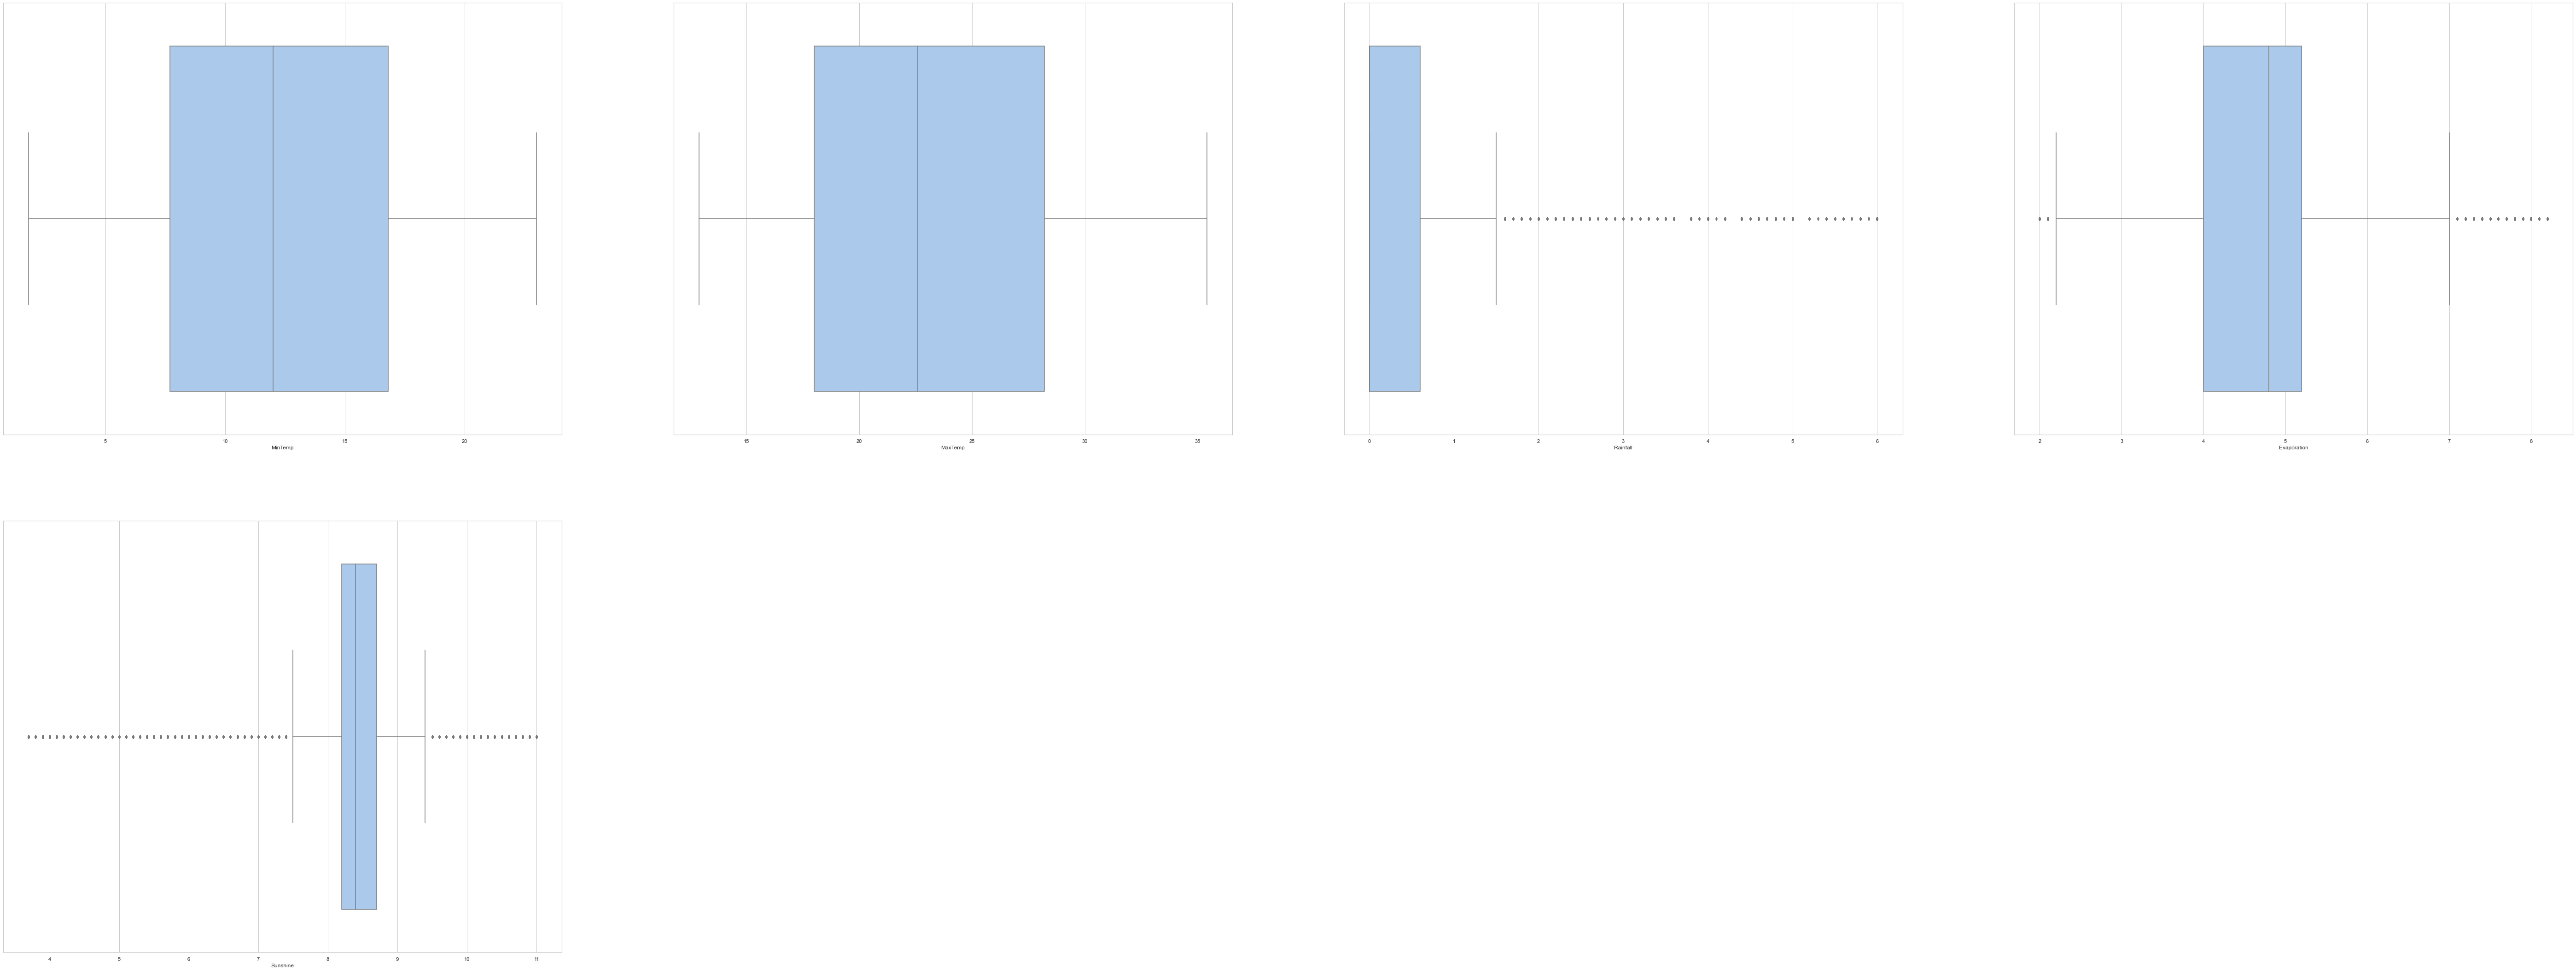

In [42]:
# lets plot em all in boxplots 

plt.figure(figsize = (100, 100))


plt.subplot(5,4,1)
sns.boxplot(merged[lst[0]])

plt.subplot(5,4,2)
sns.boxplot(merged[lst[1]])

plt.subplot(5,4,3)
sns.boxplot(merged[lst[2]])

plt.subplot(5,4,4)
sns.boxplot(merged[lst[3]])

plt.subplot(5,4,5)
sns.boxplot(merged[lst[4]])

plt.show()





In [43]:
# day has a strange distribution, look at the value counts 

merged['day'].value_counts()

# I guess this just doesnt want to plot nice, distribution looks good though 

16    4786
15    4786
2     4786
3     4786
4     4786
5     4786
6     4786
7     4786
8     4786
9     4786
10    4786
11    4786
12    4786
13    4786
14    4786
1     4786
17    4786
18    4786
19    4786
20    4786
21    4786
22    4786
23    4786
24    4785
25    4784
26    4736
27    4735
28    4735
29    4449
30    4351
31    2807
Name: day, dtype: int64

C:\conda\lib\site-packages\seaborn\distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


<AxesSubplot:xlabel='Rainfall', ylabel='Density'>

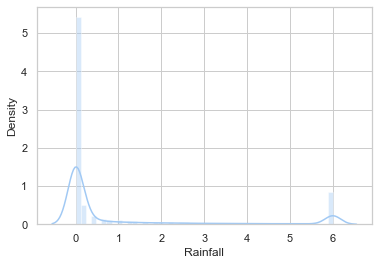

In [44]:
sns.distplot(merged['Rainfall'])

#just has a distribution like this... makes sense though 

Rainfall is just not normal. It has a wild distribution due to random extreme events and a variety of locations surveyed in the dataset. 

At this point, I am happy with the data. It has been encoded, outliers have been removed, and all the features are ready for the model. It is time to split up the X, Y and the training and test sets 

In [45]:
merged.columns

Index([      'MinTemp',       'MaxTemp',      'Rainfall',   'Evaporation',
            'Sunshine',   'WindGustDir', 'WindGustSpeed',    'WindDir9am',
          'WindDir3pm',  'WindSpeed9am',  'WindSpeed3pm',   'Humidity9am',
         'Humidity3pm',   'Pressure9am',   'Pressure3pm',      'Cloud9am',
            'Cloud3pm',       'Temp9am',       'Temp3pm',     'RainToday',
        'RainTomorrow',               0,               1,               2,
                     3,               4,               5,               6,
                     7,               8,               9,              10,
                    11,              12,              13,              14,
                    15,              16,              17,              18,
                    19,              20,              21,              22,
                    23,              24,              25,              26,
                    27,              28,              29,              30,
                    31,  

In [73]:
corr = merged[[     'MinTemp',       'MaxTemp',      'Rainfall',   'Evaporation',
            'Sunshine',   'WindGustDir', 'WindGustSpeed',    'WindDir9am',
          'WindDir3pm',  'WindSpeed9am',  'WindSpeed3pm',   'Humidity9am',
         'Humidity3pm',   'Pressure9am',   'Pressure3pm',      'Cloud9am',
            'Cloud3pm',       'Temp9am',       'Temp3pm',     'RainToday',
        'RainTomorrow', 'year', 'month', 'day']].corr()

<AxesSubplot:>

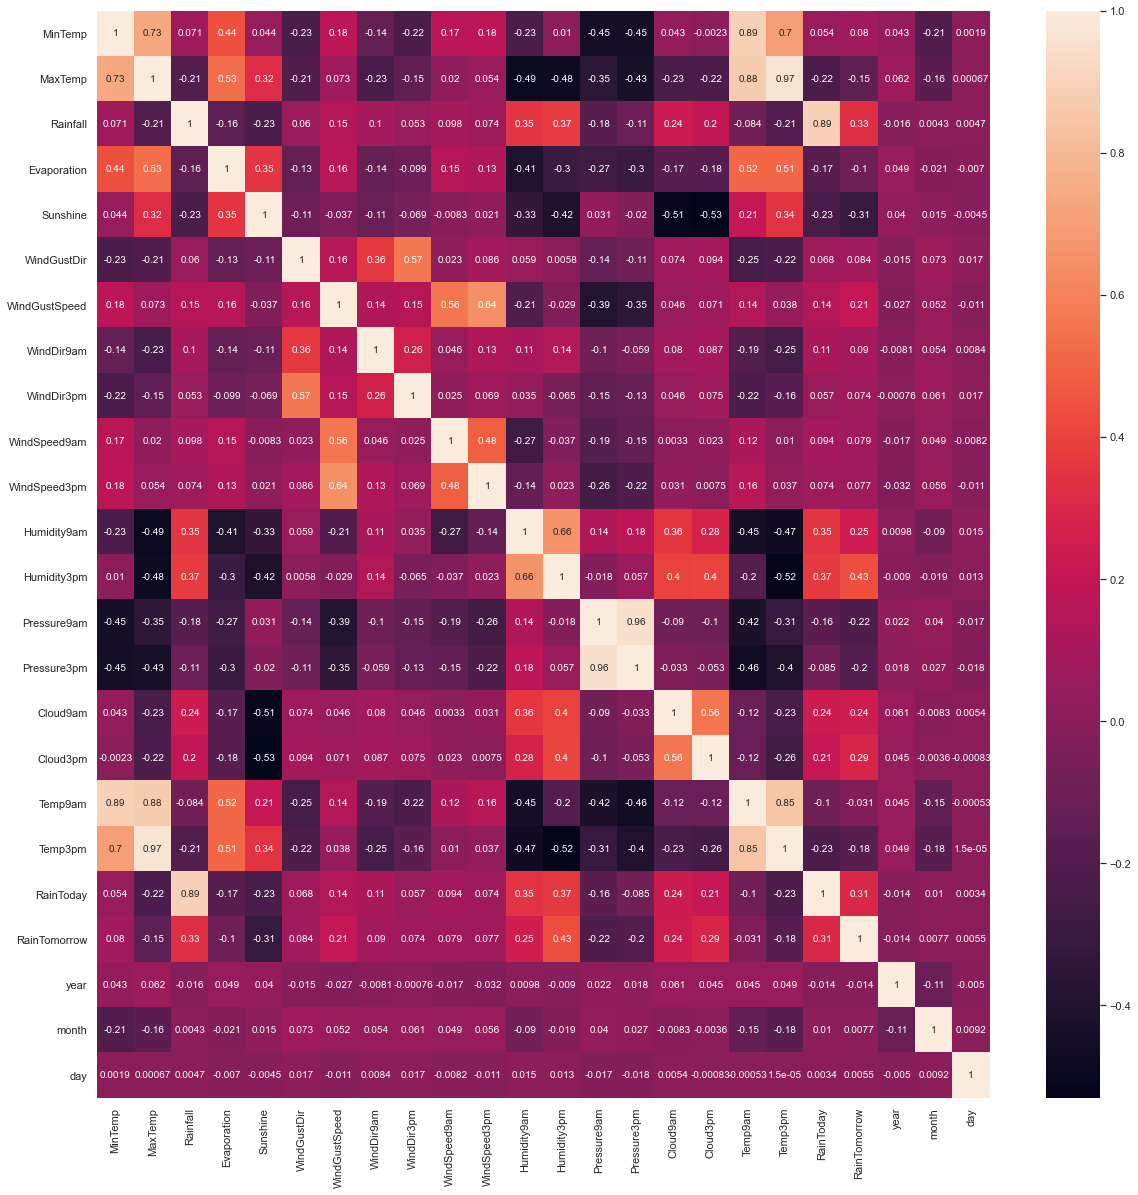

In [74]:
fig, ax = plt.subplots(figsize=(20,20))  
sns.heatmap(corr, annot=True)


Here is the updated correlation. Most of the differences seem to be slight compared to the original heatmap. 

Lets try all the features larger than absolute value 0.10. Additionally, including the location data seems important, as weather varies greatly between locations in the dataset.  

In [75]:
X = merged.copy()
X.drop(columns = ['MinTemp', 'WindGustDir', 'WindDir9am', 'WindDir3pm', 'WindSpeed3pm', 'Temp9am', 'RainTomorrow', 'year', 'month', 'day'], inplace=True)

In [76]:
X.head()

,MaxTemp,Rainfall,Evaporation,Sunshine,WindGustSpeed,WindSpeed9am,Humidity9am,Humidity3pm,Pressure9am,Pressure3pm,...,39,40,41,42,43,44,45,46,47,48
0,22.9,0.6,4.8,8.4,44.0,20.0,71.0,22.0,1009.2,1007.1,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,25.1,0.0,4.8,8.4,44.0,4.0,44.0,25.0,1010.6,1007.8,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,25.7,0.0,4.8,8.4,46.0,19.0,38.0,30.0,1009.2,1008.7,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,28.0,0.0,4.8,8.4,26.0,11.0,45.0,16.0,1017.6,1012.8,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,32.3,1.0,4.8,8.4,41.0,7.0,82.0,33.0,1010.8,1006.8,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [77]:
# now scale the features 

from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()

scaler.fit(X)

X = scaler.fit_transform(X)

X = pd.DataFrame(X)

In [78]:
X.head()

,0,1,2,3,4,5,6,7,8,9,...,53,54,55,56,57,58,59,60,61,62
0,-0.046657,-0.205794,-0.049345,0.151838,0.454124,0.874555,0.111308,-1.443652,-1.589057,-1.525789,...,-0.1461,-0.146076,-0.104725,-0.145338,-0.145264,-0.145338,-0.145338,-0.145338,-0.1461,-0.145338
1,0.290847,-0.511379,-0.049345,0.151838,0.454124,-1.369306,-1.320650,-1.297105,-1.326617,-1.394864,...,-0.1461,-0.146076,-0.104725,-0.145338,-0.145264,-0.145338,-0.145338,-0.145338,-0.1461,-0.145338
2,0.382893,-0.511379,-0.049345,0.151838,0.656213,0.734314,-1.638863,-1.052860,-1.589057,-1.226533,...,-0.1461,-0.146076,-0.104725,-0.145338,-0.145264,-0.145338,-0.145338,-0.145338,-0.1461,-0.145338
3,0.735738,-0.511379,-0.049345,0.151838,-1.364681,-0.387617,-1.267615,-1.736746,-0.014416,-0.459691,...,-0.1461,-0.146076,-0.104725,-0.145338,-0.145264,-0.145338,-0.145338,-0.145338,-0.1461,-0.145338
4,1.395405,-0.002071,-0.049345,0.151838,0.150990,-0.948582,0.694699,-0.906314,-1.289125,-1.581899,...,-0.1461,-0.146076,-0.104725,-0.145338,-0.145264,-0.145338,-0.145338,-0.145338,-0.1461,-0.145338


In [79]:
# get the targed seperated 

y = merged['RainTomorrow']

In [80]:
# now do the split train test 

from sklearn.model_selection import train_test_split

x_train, x_test, y_train, y_test = train_test_split(X, y, test_size = 0.25, shuffle = True, stratify = y)

Ok, so the data is prepared and ready for some models. Lets try fitting the RandomForestClassifier first and see how it performs. 



In [81]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_val_score

rfc = RandomForestClassifier()

scores = cross_val_score(rfc, X, y, scoring = 'neg_mean_squared_error', cv=3)

scores = np.sqrt(-scores)

In [82]:
def display_scores(scores):
    print('scores:', scores)
    print('mean:', scores.mean())

In [83]:
display_scores(scores)

scores: [0.40377393 0.4556563  0.39817158]
mean: 0.4192006052580813


In [84]:
# just try the score of the train test split 

rfc.fit(x_train, y_train)

rfc.score(x_test, y_test)

#performance seems solid 

0.8554929190155369

In [85]:
from sklearn.metrics import classification_report 

predictions = rfc.predict(x_test)

report = classification_report(y_test, predictions, target_names= ['no rain', 'rain'])

print(report)

              precision    recall  f1-score   support

     no rain       0.87      0.96      0.91     28396
        rain       0.76      0.50      0.60      7969

    accuracy                           0.86     36365
   macro avg       0.82      0.73      0.76     36365
weighted avg       0.85      0.86      0.84     36365



Lets compare this accuracy to that of the dummy classifier. 

In [86]:
from sklearn.dummy import DummyClassifier

dummy = DummyClassifier(strategy = 'most_frequent')

dummy.fit(x_train, y_train)

dummy.score(x_test, y_test)

0.7808607177230854

Pretty solid performance compared to the rfc classifier. Lets try another model. stochastic gradient descent classifier 

In [87]:
from sklearn.linear_model import SGDClassifier

sgd = SGDClassifier()

sgd.fit(x_train, y_train)

sgd.score(x_test, y_test)

# a little lower performance than the random forest classifier 

0.8437508593427746

In [88]:
predictions = sgd.predict(x_test)

report = classification_report(y_test, predictions, target_names= ['no rain', 'rain'])

print(report)

              precision    recall  f1-score   support

     no rain       0.87      0.94      0.90     28396
        rain       0.71      0.49      0.58      7969

    accuracy                           0.84     36365
   macro avg       0.79      0.72      0.74     36365
weighted avg       0.83      0.84      0.83     36365



The f1-score is the best metric to compare the models in this case. Since it quantifies both the recall and  precision, it is a more suitable metric than precision alone. 

Lets try a Support Vector Machine. This model might not be the best choice for this dataset due to the number of features and size, but its still worth a try. 

In [89]:
# from sklearn.svm import SVC 

# svc = SVC()

# svc.fit(x_train, y_train)

# svc.score(x_test, y_test)

This model took too long to fit, and resulted in no significiant increase in accuracy. Not worth using this one. It took so long that it is not worth investigating any further. 

Lets try one last model, the k neighbors classifier


In [90]:
# from sklearn.neighbors import KNeighborsClassifier

# neigh = KNeighborsClassifier()

# neigh.fit(x_train, y_train)

# neigh.score(x_test, y_test)

# less than all the other models, and still very slow 

In [91]:
from sklearn.tree import DecisionTreeClassifier 

treeclass = DecisionTreeClassifier()

treeclass.fit(x_train, y_train) 

treeclass.score(x_test, y_test) 

# poor performance, only a tiny bit better than the dummy classifier. 

0.7870204867317475

The decision tree is not worth investigating any further. It produced accuracy nearly identical to the dummy classifier. 

The random forest classifier is the best model out of these 3. It was able to fit in a relatively timely manner, and had the highest accuracy as well as f1 score of all the models that were tested. Lets use a random search to get the best params for the model 

In [92]:
# from sklearn.model_selection import RandomizedSearchCV

params = dict()
params['max_depth'] = np.arange(1, 120, 5)
params['max_features'] = [2, 3]
params['min_samples_leaf'] = [3, 4, 5]
params['min_samples_split'] = [8, 10, 12]
params['n_estimators'] = [100, 200, 300, 500, 700, 1000]

#search = RandomizedSearchCV(rfc, params, cv=3, n_jobs=-1, verbose=2)

#search.fit(X, y)

In [93]:
# search.best_estimator_

In [94]:
rfc = RandomForestClassifier(max_depth=91, max_features=2, min_samples_leaf=4,
                       min_samples_split=12)

rfc.fit(x_train, y_train)

RandomForestClassifier(max_depth=91, max_features=2, min_samples_leaf=4,
                       min_samples_split=12)

In [95]:
rfc.score(x_test, y_test)

0.8465282551904304

We got a lowers score here than for the the original model. This is because the original Random Forest Classifier fit to the x_train, y_train data was overfitting the data. The hyperparameter tuning process utilized cross validation, therefore it picked a several unique datasets from the features and target to validate the model. This produces a better predicative and generalizing model than the original method, as it reduces overfitting. Since the model was subjected to 3 cross validation folds during hyperparameter tuning, these parameters are better at predicting the overall dataset, rather than a single train test split set. The goal here is to produce a model that can predict as accuratly as possible, not fit the training data as accuratly as possible. 

In [96]:
def plot_confusion_matrix(cm,
                          target_names,
                          title='Confusion matrix',
                          cmap=None,
                          normalize=True):
    """
 
    Citiation
    ---------
    http://scikit-learn.org/stable/auto_examples/model_selection/plot_confusion_matrix.html

    """
    import matplotlib.pyplot as plt
    import numpy as np
    import itertools

    accuracy = np.trace(cm) / float(np.sum(cm))
    misclass = 1 - accuracy

    if cmap is None:
        cmap = plt.get_cmap('Blues')

    plt.figure(figsize=(8, 6))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()

    if target_names is not None:
        tick_marks = np.arange(len(target_names))
        plt.xticks(tick_marks, target_names, rotation=45)
        plt.yticks(tick_marks, target_names)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]


    thresh = cm.max() / 1.5 if normalize else cm.max() / 2
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        if normalize:
            plt.text(j, i, "{:0.4f}".format(cm[i, j]),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")
        else:
            plt.text(j, i, "{:,}".format(cm[i, j]),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")


    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label\naccuracy={:0.4f}; misclass={:0.4f}'.format(accuracy, misclass))
    plt.show()

In [97]:
from sklearn.metrics import confusion_matrix 

predictions = rfc.predict(x_test)

confusion = confusion_matrix(y_test, predictions, labels= [1,0], normalize='true')

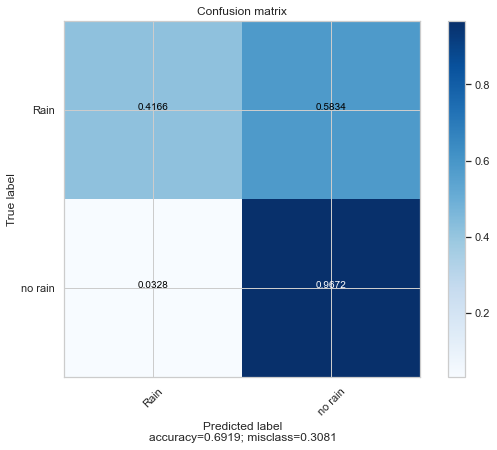

In [98]:
plot_confusion_matrix(confusion, target_names = ['Rain', 'no rain'])

The confusion matrix shows what sort of mistakes the model is making. This model makes the majority of its' mistakes predicting the days it does in fact rain. 

Despite this, I am impressed with the accuracy of this model. Taking into account that it is utilizing only the current day's weather to predict if it will rain tomorrow, and includes 50 cities with desert to tropical environments it is accurate. 

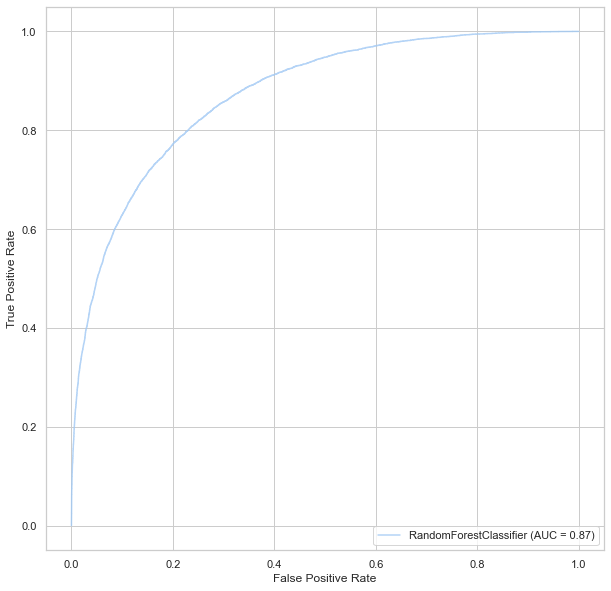

In [99]:
from sklearn.metrics import plot_roc_curve 

plt.figure(figsize= (10, 10))
ax = plt.gca()
rfc_disp = plot_roc_curve(rfc, x_test, y_test, ax=ax, alpha = 0.8)
plt.show()

A final figure, the ROC curve. It is comparing the true positive rate (actual positive class predicted so) versus the false positive rate ( predicted positive but actually false). An optimal curve would be a perfect 90 degree right angle. 